# Data analysis of project for CS-A1155 - Databases for Data Science

### Group 14: Benjamin Herman, Quoc Quang Ngo, Thinh Nguyen

In [2]:
# import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import sqlalchemy
from datetime import date


def conditional_commit():
    """Commit if major version number is greater than 1"""
    if int(sqlalchemy.__version__.split('.')[0]) > 1:
        psql_conn.commit()


in_script = False
cred_file = 'credentials.json'
# cred_file = 'credentials.json'
# use 'credentials.json' to connect to the remote database

# Load a dictionary of credentials
with open(cred_file) as fp:
    creds = json.load(fp)

db_url = 'postgresql+psycopg2://' + \
    '{user}:{password}@{host}:{port}/{database}'. \
    format(**creds)

engine = create_engine(db_url)


**Question 1**

In [3]:

with engine.connect() as psql_conn:
    # 1.
    diagnoses = pd.read_sql_table('diagnosis', psql_conn)
    diagnoses.rename({'patient': 'ssno', 'reportdate': 'diagnosisdate'},
                     axis=1, inplace=True)

    patients = pd.read_sql_table('patients', psql_conn)
    patients.drop('name', axis=1, inplace=True)

    patientsymptoms = pd.merge(patients, diagnoses,
                               on='ssno', how='right')

    patientsymptoms = patientsymptoms[['ssno', 'gender', 'dateofbirth',
                                       'symptom', 'diagnosisdate']]

    patientsymptoms.to_sql('patientsymptoms', psql_conn,
                           if_exists='replace', index=True)

    conditional_commit()


**Question 2**

In [4]:
with engine.connect() as psql_conn:
    # 2.
    vaccpats = pd.read_sql_table('vaccinepatients', psql_conn)
    vaccinations = pd.read_sql_table('vaccinations', psql_conn)
    batches = pd.read_sql_table('vaccinebatch', psql_conn)

    batches.drop(['numvaccines', 'manufacturer', 'dateproduced',
                  'expirationdate', 'location'],
                 axis=1, inplace=True)

    vaccpats = pd.merge(vaccpats, vaccinations,
                        on=('vaccinationdate', 'location'),
                        how='left')

    vaccpats = pd.merge(vaccpats, batches,
                        on='batchid',
                        how='left')

    vaccpats.sort_values(by='vaccinationdate', inplace=True)

    vaccpats.rename({'patientssno': 'ssno'}, inplace=True, axis=1)

    nulls = [None] * patients.shape[0]
    pvi = pd.concat([patients.ssno,
                    pd.DataFrame({'date1': nulls,
                                  'vaccinetype1': nulls,
                                  'date2': nulls,
                                  'vaccinetype2': nulls})],
                    axis=1)

    pvi.set_index('ssno', inplace=True)
    for _, row in vaccpats.iterrows():
        if pvi.isna().loc[row.ssno, 'date1']:
            pvi.loc[row.ssno, 'date1'] = row.vaccinationdate
            pvi.loc[row.ssno, 'vaccinetype1'] = row.vaccineid
        elif pvi.isna().loc[row.ssno, 'date2']:
            pvi.loc[row.ssno, 'date2'] = row.vaccinationdate
            pvi.loc[row.ssno, 'vaccinetype2'] = row.vaccineid
        else:
            raise Exception('Third vaccination found')

    pvi.reset_index(inplace=True)
    pvi.to_sql('patientvaccineinfo', psql_conn,
               if_exists='replace', index=True)

    conditional_commit()

**Question 3**

In [5]:
with engine.connect() as psql_conn:
    # 3.
    patientsymptoms = pd.read_sql_table('patientsymptoms', psql_conn)

    patientsymptoms_m = patientsymptoms[patientsymptoms.gender == 'M']
    patientsymptoms_f = patientsymptoms[patientsymptoms.gender == 'F']

    print()
    print('Top three symptoms in males')
    print(patientsymptoms_m.symptom.value_counts()[:3])
    print()
    print()
    print('Top three symptoms in females')
    print(patientsymptoms_f.symptom.value_counts()[:3])
    print()



Top three symptoms in males
joint pain     10
muscle ache     7
fever           6
Name: symptom, dtype: int64


Top three symptoms in females
muscle ache            8
headache               7
feelings of illness    4
Name: symptom, dtype: int64



**Question 4**

In [6]:
with engine.connect() as psql_conn:
    # 4.
    patients_df = pd.read_sql_table('patients', psql_conn)
    print(patients_df['dateofbirth'].dtypes)
    today = date.today()
    patients_df['age'] = patients_df['dateofbirth'].apply(
        lambda x: today.year - x.year - 
        ((today.month, today.day) < (x.month, x.day)))
    
    bins= [0,10,20,40,60,200]
    labels = ['0-10','10-20','20-40','40-60','60+']
    patients_df['ageGroup'] = pd.cut(patients_df['age'], bins=bins,
                                     labels=labels, right=False)
    patients_df = patients_df.drop(columns=['age'])
    print(patients_df)


datetime64[ns]
            ssno                   name dateofbirth gender ageGroup
0    841229-112N       Rodolfo O'Reilly  1984-12-29      M    20-40
1    780214-1893  Prof. Erling Morar MD  1978-02-14      F    40-60
2    950303-191X  Dr. Simeon Keeling II  1995-03-03      M    20-40
3    730218-253D            Dereck Beer  1973-02-18      M    40-60
4    971214-2818   Prof. Brice Metz PhD  1997-12-14      M    20-40
..           ...                    ...         ...    ...      ...
145  881210-971J        Brain Greenholt  1988-12-10      M    20-40
146  110614-978B      Ms. Hanna Corkery  2011-06-14      F    10-20
147  830908-9826               Ana Ward  1983-09-08      F    20-40
148  080305-985A             Ricky Kuhn  2008-03-05      M    10-20
149  011119-9865          Ahmad Kovacek  2001-11-19      M    20-40

[150 rows x 5 columns]


A new column 'ageGroup' is added to the dataframe. Age calculation is done
by finding the difference between today and a person's date of birth. Leap
years are also considered in the calculation to ensure that special days
like February 29 do not affect the results.

**Question 5**

In [7]:
with engine.connect() as psql_conn:
    # 5
    statement = '''
    -- the number of vaccines a patient has had so far
    SELECT DISTINCT p.ssno As patientSsNo, COUNT(*) AS vaccinationstatus
    FROM patients p
    JOIN vaccinepatients vp ON p.ssno = vp.patientssno
    GROUP BY p.ssno;
        '''
    result = psql_conn.execute(text(statement))
    out = result.fetchall()
    column_names = list(result.keys())
    df = pd.DataFrame.from_records(out, columns=column_names)
    output_string = df.to_string(index=False)
    
    merged_df = pd.merge(patients_df, df, left_on='ssno',
                         right_on='patientssno',
                         how='left').drop('patientssno', axis=1)
    merged_df['vaccinationstatus'] = merged_df['vaccinationstatus'] \
        .fillna(0).astype('int64')
    merged_df.rename({'vaccinationstatus': 'vaccinationStatus'},
                     axis=1, inplace=True)
    print(merged_df)
    

            ssno                   name dateofbirth gender ageGroup  \
0    841229-112N       Rodolfo O'Reilly  1984-12-29      M    20-40   
1    780214-1893  Prof. Erling Morar MD  1978-02-14      F    40-60   
2    950303-191X  Dr. Simeon Keeling II  1995-03-03      M    20-40   
3    730218-253D            Dereck Beer  1973-02-18      M    40-60   
4    971214-2818   Prof. Brice Metz PhD  1997-12-14      M    20-40   
..           ...                    ...         ...    ...      ...   
145  881210-971J        Brain Greenholt  1988-12-10      M    20-40   
146  110614-978B      Ms. Hanna Corkery  2011-06-14      F    10-20   
147  830908-9826               Ana Ward  1983-09-08      F    20-40   
148  080305-985A             Ricky Kuhn  2008-03-05      M    10-20   
149  011119-9865          Ahmad Kovacek  2001-11-19      M    20-40   

     vaccinationStatus  
0                    2  
1                    1  
2                    1  
3                    1  
4                    1

A new column 'vaccinationStatus' is added to the dataframe.
The value '0' represents 'not vaccinated', '1' for 'vaccinated once',
and '2' for 'fully-vaccinated'.

**Question 6**

In [8]:
with engine.connect() as psql_conn:
    # 6
    df2 = pd.pivot_table(merged_df, index='vaccinationStatus', 
                         values='ssno', 
                         columns='ageGroup',
                         aggfunc='count')
    
    df2['0-10'] = round((df2['0-10']/df2['0-10'].sum())*100, 2). \
                       fillna(0).astype(str) + '%'
    df2['10-20'] = round((df2['10-20']/df2['10-20'].sum())*100, 2). \
                        fillna(0).astype(str) + '%'
    df2['20-40'] = round((df2['20-40']/df2['20-40'].sum())*100, 2). \
                        fillna(0).astype(str) + '%'
    df2['40-60'] = round((df2['40-60']/df2['40-60'].sum())*100, 2). \
                        fillna(0).astype(str) + '%'
    df2['60+'] = round((df2['60+']/df2['60+'].sum())*100, 2). \
                      fillna(0).astype(str) + '%'
    print(df2)

ageGroup             0-10   10-20   20-40  40-60   60+
vaccinationStatus                                     
0                  57.14%  35.14%  32.69%  52.5%  0.0%
1                  33.33%  56.76%  55.77%  45.0%  0.0%
2                   9.52%   8.11%  11.54%   2.5%  0.0%


A spreadsheet-style pivot table as a dataFrame is created and shows
the percentage of patients who have received zero, one, or two doses
of vaccines by age group. It is noteworthy that there are no patients
who age over 60 in the sample data and therefore the age group 60+
has no vaccination status data.

**Question 7**

In [9]:
with engine.connect() as psql_conn:
    sql = """
    select vt.id, d.symptom, count(d.symptom) as count,
    round(cast(count(d.symptom) AS Numeric)/
          cast(vaccinationcount AS Numeric),2) as frequency
from vaccinetype vt
left join vaccinebatch vb on vb.vaccineid = vt.id
left join vaccinations v on v.batchid = vb.batchid
left join vaccinepatients vp on v.vaccinationdate = v.vaccinationdate
    and v.location = vp.location
left join diagnosis d on d.patient = vp.patientssno,
(select vt.id, count(vt.id) as vaccinationcount
	from vaccinetype vt
	left join vaccinebatch vb on vb.vaccineid = vt.id
	left join vaccinations v on v.batchid = vb.batchid
	left join vaccinepatients vp
	    on v.vaccinationdate = v.vaccinationdate
	    and v.location = vp.location
	group by vt.id
) AS vaccinationcases
where d.reportdate::date >= v.vaccinationdate
    and vaccinationcases.id = vt.id
group by d.symptom, vt.id, vaccinationcount
order by vt.id, count DESC;
    """
    result = psql_conn.execute(text(sql))
    out = result.fetchall()
    df = pd.DataFrame.from_records(out, columns =
        ['id', 'symptom', 'count','frequency'])
    df = df.drop('count', axis=1)

    v01 = df[df['id'] == 'V01']
    v02 = df[df['id'] == 'V02']
    v03 = df[df['id'] == 'V03']

    v01 = v01.drop('id', axis=1)
    v01.columns = ['symptom', 'V01']
    v02 = v02.drop('id', axis=1)
    v02.columns = ['symptom', 'V02']
    v03 = v03.drop('id', axis=1)
    v03.columns = ['symptom', 'V03']
    merged_df = pd.merge(v01, v02, on='symptom', how='outer')

    final_df = pd.merge(merged_df, v03, on='symptom', how='outer')
    final_df.fillna(0, inplace=True)
    def map_frequency(frequency):
        if frequency >= 0.1:
            return 'very common'
        elif frequency >= 0.05:
            return 'common'
        elif frequency > 0.0:
            return 'rare'
        else:
            return '-'

    final_df['V01'] = final_df['V01'].map(map_frequency)
    final_df['V02'] = final_df['V02'].map(map_frequency)
    final_df['V03'] = final_df['V03'].map(map_frequency)
    print(final_df)



                        symptom          V01          V02          V03
0                   muscle ache  very common  very common       common
1                    joint pain  very common       common         rare
2                      headache  very common         rare  very common
3                        nausea  very common         rare            -
4      itchiness near injection       common            -            -
5                         fever       common         rare       common
6         warmth near injection       common            -            -
7                    high fever       common         rare         rare
8                      diarrhea         rare            -         rare
9                      vomiting         rare         rare            -
10          feelings of illness         rare       common            -
11  inflammation near injection         rare            -         rare
12                      fatigue         rare         rare         rare
13    

**Question 8**

In [10]:
with engine.connect() as psql_conn:
    sql = """
 select (count(vp.patientssno) /cast(vb.numvaccines as numeric))
    as percentage
from vaccinations v
left join vaccinebatch vb on v.batchid = vb.batchid
left join vaccinepatients vp on v.vaccinationdate = vp.vaccinationdate
    and v.location = vp.location
group by  v.vaccinationdate,v.location,vb.numvaccines ;
    """
    result = psql_conn.execute(text(sql))
    out = result.fetchall()
    df = pd.DataFrame.from_records(out, columns=["percentage"])
    df['percentage'] = df['percentage'].astype(float)
    exp = float(df.mean())
    sd =  float(df['percentage'].std())
    print("As a percentage at least " + str((exp + sd)*100) +
          "% of the total vaccines should be reserved.")


As a percentage at least 97.35961804419983% of the total vaccines should be reserved.


**Question 9**

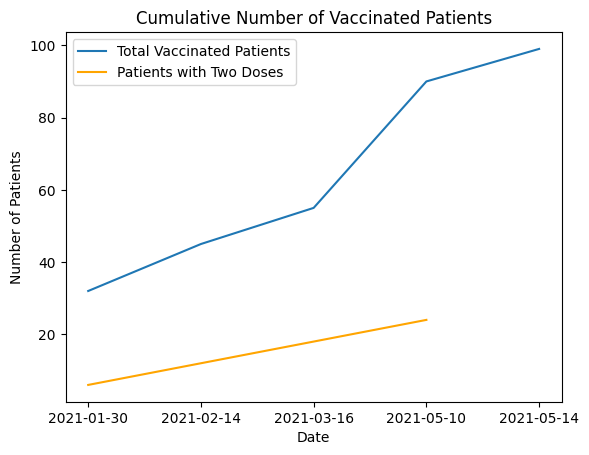

In [11]:
with engine.connect() as psql_conn:
    df = pd.read_sql_table('vaccinepatients', psql_conn)
df.rename({'vaccinationdate': 'date',
           'patientssno': 'patientSsNo'}, axis=1, inplace=True)
grouped_total = df.groupby('date')['patientSsNo'].nunique().reset_index()
grouped_total['cumulative_sum'] = grouped_total['patientSsNo'].cumsum()
two_dose_patients = df.groupby('patientSsNo').filter(lambda x: len(x) >= 2)
grouped_two_dose = two_dose_patients.groupby('date')['patientSsNo']. \
    nunique().reset_index()
grouped_two_dose['cumulative_sum'] = \
    grouped_two_dose['patientSsNo'].cumsum()

fig, ax = plt.subplots()

_ = ax.plot(grouped_total['date'].dt.strftime('%Y-%m-%d'),
         grouped_total['cumulative_sum'], label='Total Vaccinated Patients')
_ = ax.plot(grouped_two_dose['date'].dt.strftime('%Y-%m-%d'),
         grouped_two_dose['cumulative_sum'],
         color='orange', label='Patients with Two Doses')

_ = ax.set_xlabel('Date')
_ = ax.set_ylabel('Number of Patients')
_ = ax.set_title('Cumulative Number of Vaccinated Patients')
_ = ax.legend()

if in_script: fig.show()

**Question 10**

In [12]:
with engine.connect() as psql_conn:

    statement = '''
    -- patients that the nurse may have met in
-- vaccination events in the past 10 days
SELECT DISTINCT vp.patientssno, p.name
FROM vaccinations v
JOIN vaccinepatients vp ON v.vaccinationdate = vp.vaccinationdate
    AND v.location = vp.location
JOIN patients p ON vp.patientssno = p.ssno
JOIN staffmembers s ON v.location = s.hospital
WHERE v.vaccinationdate >= '2021-05-05'
  AND v.vaccinationdate <= '2021-05-15'
  AND s.ssno = '19740919-7140';
    '''
    result = psql_conn.execute(text(statement))
    out = result.fetchall()
    column_names = list(result.keys())
    df = pd.DataFrame.from_records(out, columns=column_names)
    output_string = df.to_string(index=False)
    print(output_string)

patientssno                name
010327-525G Dr. Mireille Hansen
060421-302M     Faustino Barton
080514-3385  Dakota Greenfelder
090226-5673    Dr. Lamont Ferry
090416-443L       Aliyah Harber
130205-474D      Elenora Sawayn
210318-737O         Corine Hane
830820-576C        Loyal Hoeger
871128-519R        Flossie Torp
930508-413K  Mr. Reid Little II
930804-509I            Fay Ryan
960629-4156       Rossie Spinka
990622-5231            Sid Hahn


In [13]:
with engine.connect() as psql_conn:
    statement = '''
-- staff members that the nurse may have met
-- in vaccination events in the past 10 days
SELECT DISTINCT s.ssno, s.name
FROM staffmembers s
JOIN shifts sh ON s.ssno = sh.worker
JOIN vaccinations v ON sh.station = v.location
WHERE v.location = (SELECT hospital FROM staffmembers
                    WHERE ssno = '19740919-7140')
  AND sh.weekday IN (SELECT weekday FROM shifts
                    WHERE worker = '19740919-7140')
  AND s.ssno != '19740919-7140';
    '''
    result = psql_conn.execute(text(statement))
    out = result.fetchall()
    column_names = list(result.keys())
    df = pd.DataFrame.from_records(out, columns=column_names)
    output_string = df.to_string(index=False)
    print(output_string)

         ssno              name
19940615-4448     Jordy Hilpert
19831020-4745  Madisyn Shanahan
19771112-4048      Greg Schuppe
19930315-7195   Jeromy McKenzie
19910122-1693 Ashley Konopelski
19920802-4854       Kaden Tromp
